In [1]:
import re
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
import string
import nltk
import warnings 
warnings.filterwarnings("ignore", category=DeprecationWarning)

%matplotlib inline

In [2]:
list_of_lists = []

with open('short/train_positive.txt') as f:
    for line in f:
        inner_list = line.splitlines()
        list_of_lists.append(inner_list)
df_tr0 = pd.DataFrame(list_of_lists)
df_tr0.columns=['tweet']
df_tr0['label']=0

list_of_lists = []

with open('short/train_negative.txt') as f:
    for line in f:
        inner_list = line.splitlines()
        list_of_lists.append(inner_list)
df_tr1 = pd.DataFrame(list_of_lists)
df_tr1.columns=['tweet']
df_tr1['label']=1

list_of_lists = []

with open('short/test_positive.txt') as f:
    for line in f:
        inner_list = line.splitlines()
        list_of_lists.append(inner_list)
df_ts0 = pd.DataFrame(list_of_lists)
df_ts0.columns=['tweet']
df_ts0['label']=0

list_of_lists = []

with open('short/test_negative.txt') as f:
    for line in f:
        inner_list = line.splitlines()
        list_of_lists.append(inner_list)
df_ts1 = pd.DataFrame(list_of_lists)
df_ts1.columns=['tweet']
df_ts1['label']=1

In [3]:
df_tr= pd.concat([df_tr0, df_tr1])
df_ts = pd.concat([df_ts0,df_ts1])
print(df_tr.shape, df_ts.shape)

(196000, 2) (4000, 2)


In [4]:
trdf = df_tr.sample(frac=1).reset_index(drop=True)
tsdf = df_ts.sample(frac=1).reset_index(drop=True)

In [5]:
combi = trdf.append(tsdf, ignore_index=True)
combi

,tweet,label
0,<user> haha ok ! i miss you too ! and we are g...,0
1,seniors ! 31 days and counting ! <url>,0
2,i wonder if <user> realizes how many times he ...,0
3,might regret going out though as i've got work...,1
4,best pick up line ever : i wasn't looking at y...,0
...,...,...
199995,"08x30 custom picture frame / poster frame 2 "" ...",1
199996,awww demetre wanted to bring me lunch ! he's s...,0
199997,#travelnews dharamshala ( indiamike share with...,1
199998,my prayers to the precipitation gods were not ...,1


In [6]:
## Remove user tag

In [7]:
def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for i in r:
        input_txt = re.sub(i, '', input_txt)
        
    return input_txt

In [8]:
combi['tidy_tweet'] = np.vectorize(remove_pattern)(combi['tweet'], "<user>*")

In [9]:
# remove special characters, numbers, punctuations
combi['tidy_tweet'] = combi['tidy_tweet'].str.replace("[^a-zA-Z#]", " ")

In [10]:
# Removing words with length shorter than 3
combi['tidy_tweet'] = combi['tidy_tweet'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))

In [11]:
# tokenization

tokenized_tweet = combi['tidy_tweet'].apply(lambda x: x.split())
tokenized_tweet.head()

0     [haha, miss, going, hang, soon, promise, sunday]
1                            [seniors, days, counting]
2    [wonder, realizes, many, times, struck, lookin...
3        [might, regret, going, though, work, morning]
4    [best, pick, line, ever, wasn, looking, your, ...
Name: tidy_tweet, dtype: object

In [12]:
# stemming 

from nltk.stem.porter import *
stemmer = PorterStemmer()

tokenized_tweet = tokenized_tweet.apply(lambda x: [stemmer.stem(i) for i in x]) # stemming
tokenized_tweet.head()

0         [haha, miss, go, hang, soon, promis, sunday]
1                                 [senior, day, count]
2    [wonder, realiz, mani, time, struck, lookin, s...
3              [might, regret, go, though, work, morn]
4    [best, pick, line, ever, wasn, look, your, boo...
Name: tidy_tweet, dtype: object

In [13]:
# stitch back tokens together 

for i in range(len(tokenized_tweet)):
    tokenized_tweet[i] = ' '.join(tokenized_tweet[i])

combi['tidy_tweet'] = tokenized_tweet

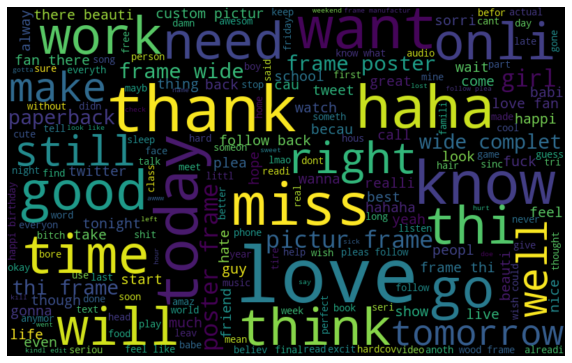

In [14]:
# word cloud of all tweets, not much info

all_words = ' '.join([text for text in combi['tidy_tweet']])
from wordcloud import WordCloud
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

(-0.5, 799.5, 499.5, -0.5)

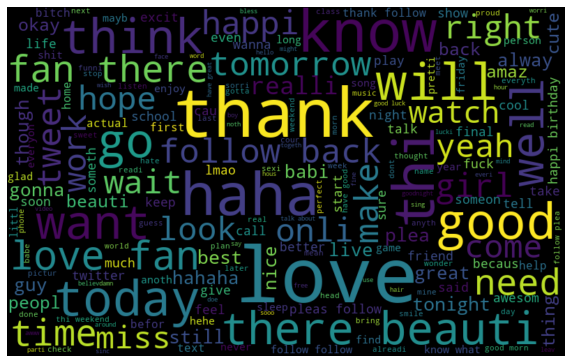

In [15]:
# word cloud of positive tweets 

normal_words =' '.join([text for text in combi['tidy_tweet'][combi['label'] == 0]])

wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(normal_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
# plt.savefig('Results/pos_wc.png', bbox_inches='tight')

(-0.5, 799.5, 499.5, -0.5)

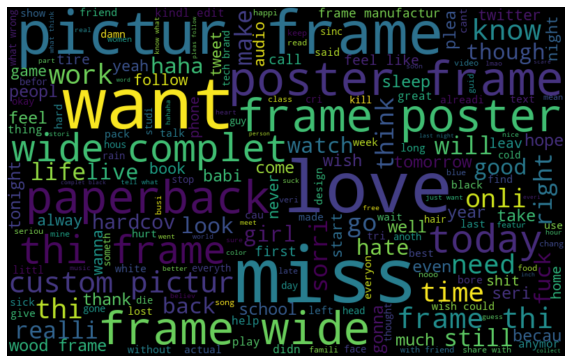

In [16]:
# Negative sentiment word cloud

negative_words = ' '.join([text for text in combi['tidy_tweet'][combi['label'] == 1]])
wordcloud = WordCloud(width=800, height=500,
random_state=21, max_font_size=110).generate(negative_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
# plt.savefig('Results/neg_wc.png', bbox_inches='tight')

In [17]:
# function to collect hashtags
def hashtag_extract(x):
    hashtags = []
    # Loop over the words in the tweet
    for i in x:
        ht = re.findall(r"#(\w+)", i)
        hashtags.append(ht)

    return hashtags

In [18]:
# extracting hashtags from positive tweets

HT_regular = hashtag_extract(combi['tidy_tweet'][combi['label'] == 0])

# extracting hashtags from negative tweets
HT_negative = hashtag_extract(combi['tidy_tweet'][combi['label'] == 1])

# unnesting list
HT_regular = sum(HT_regular,[])
HT_negative = sum(HT_negative,[])

<Figure size 1152x360 with 0 Axes>

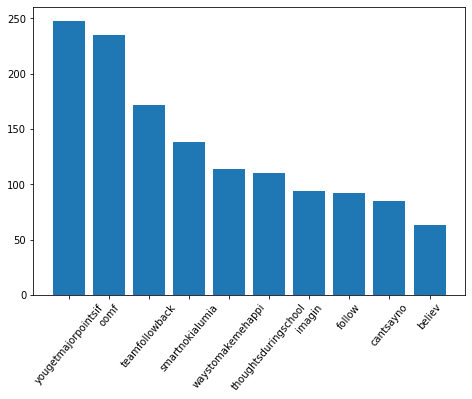

In [19]:
# histogram for hashtags in positive tweets

a = nltk.FreqDist(HT_regular)
d = pd.DataFrame({'Hashtag': list(a.keys()),
                  'Count': list(a.values())})
# selecting top 10 most frequent hashtags     
d = d.nlargest(columns="Count", n = 10) 
plt.figure(figsize=(16,5))

# ax = sns.barplot(data=d, x= "Hashtag", y = "Count")
# ax.set(ylabel = 'Count')

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
# langs = ['C', 'C++', 'Java', 'Python', 'PHP']
# students = [23,17,35,29,12]
ax.bar(d['Hashtag'],d['Count'])
plt.xticks(rotation=50)
# plt.savefig('Results/pos_htags.png', bbox_inches='tight')
plt.show()


<Figure size 1152x360 with 0 Axes>

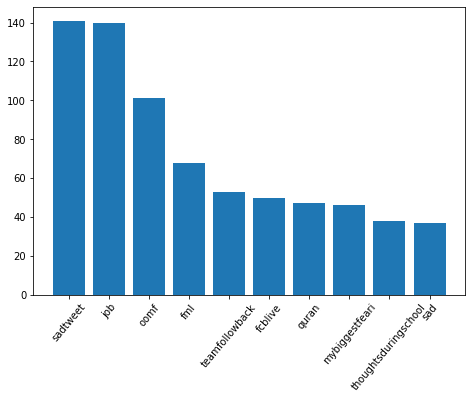

In [20]:
# histogram for hashtags in negative tweets 

a = nltk.FreqDist(HT_negative)
d = pd.DataFrame({'Hashtag': list(a.keys()),
                  'Count': list(a.values())})
# selecting top 10 most frequent hashtags     
d = d.nlargest(columns="Count", n = 10) 
plt.figure(figsize=(16,5))

# ax = sns.barplot(data=d, x= "Hashtag", y = "Count")
# ax.set(ylabel = 'Count')

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
# langs = ['C', 'C++', 'Java', 'Python', 'PHP']
# students = [23,17,35,29,12]
ax.bar(d['Hashtag'],d['Count'])
plt.xticks(rotation=50)
# plt.savefig('Results/neg_htags.png', bbox_inches='tight')
plt.show()

In [21]:
# bow features

from sklearn.feature_extraction.text import CountVectorizer
bow_vectorizer = CountVectorizer(max_df=0.90, min_df=2, max_features=1000, stop_words='english')
# bag-of-words feature matrix
bow = bow_vectorizer.fit_transform(combi['tidy_tweet'])

In [22]:
# tf-idf features

from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(max_df=0.90, min_df=2, max_features=1000, stop_words='english')
# TF-IDF feature matrix
tfidf = tfidf_vectorizer.fit_transform(combi['tidy_tweet'])

In [23]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

train_bow = bow
# test_bow = bow[196000:,:]

# splitting data into training and validation set
xtrain_bow, xvalid_bow, ytrain, yvalid = train_test_split(train_bow, combi['label'], random_state=42, test_size=0.3)

lreg_bow = LogisticRegression()
lreg_bow.fit(xtrain_bow, ytrain) # training the model

prediction = lreg_bow.predict_proba(xvalid_bow) # predicting on the validation set
prediction_int = prediction[:,1] >= 0.3 # if prediction is greater than or equal to 0.3 than 1 else 0
prediction_int = prediction_int.astype(np.int)

f1_score(yvalid, prediction_int) # calculating f1 score

C:\Users\risha\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


0.7455179620808057

In [24]:
train_tfidf = tfidf
# test_tfidf = tfidf[31962:,:]

xtrain_tfidf = train_tfidf[ytrain.index]
xvalid_tfidf = train_tfidf[yvalid.index]

lreg_tf = LogisticRegression()
lreg_tf.fit(xtrain_tfidf, ytrain)

prediction = lreg_tf.predict_proba(xvalid_tfidf)
prediction_int = prediction[:,1] >= 0.3
prediction_int = prediction_int.astype(np.int)

f1_score(yvalid, prediction_int)

C:\Users\risha\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


0.7464201854038574

In [ ]:
# # SVM Classifier

# from sklearn import svm
# clf = svm.SVC(kernel='rbf')
# clf = clf.fit(xtrain_bow, ytrain)
# predictions = clf.predict(xvalid_bow)
# predictions

In [ ]:
# # Random Forest 
# from sklearn.ensemble import RandomForestClassifier

# # Create the model with 100 trees
# model = RandomForestClassifier(n_estimators=50, 
#                                bootstrap = True,
#                                max_features = 'sqrt')
# # Fit on training data
# model.fit(xtrain_bow, ytrain)

In [ ]:
# prediction = model.predict_proba(xvalid_bow)[:, 1]
# prediction_int = prediction >= 0.3 # if prediction is greater than or equal to 0.3 than 1 else 0
# prediction_int = prediction_int.astype(np.int)
# f1_score(yvalid, prediction_int) # calculating f1 score

In [25]:
list_of_lists = []

with open('test_data.txt') as f:
    for line in f:
        inner_list = line.splitlines()
        list_of_lists.append(inner_list)
ts = pd.DataFrame(list_of_lists)
ts.columns=['tweet']
id_list= []
tw_list=[]
for i in range(0, ts.shape[0]):
    x= ts['tweet'][i]
    x1= x.split(",", 1)
    id_list.append(x1[0])
    tw_list.append(x1[1])

In [26]:
ts['id']= id_list
ts['tweet']= tw_list
ts['tweet'] = np.vectorize(remove_pattern)(ts['tweet'], "<user>*")
ts['tweet'] = ts['tweet'].str.replace("[^a-zA-Z#]", " ")
ts['tweet'] = ts['tweet'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))
tokenized_tweet = ts['tweet'].apply(lambda x: x.split())
stemmer = PorterStemmer()
tokenized_tweet = tokenized_tweet.apply(lambda x: [stemmer.stem(i) for i in x])
for i in range(len(tokenized_tweet)):
    tokenized_tweet[i] = ' '.join(tokenized_tweet[i])

ts['tweet'] = tokenized_tweet
tsbow = bow_vectorizer.transform(ts['tweet'])
tstfidf = tfidf_vectorizer.transform(ts['tweet'])

In [27]:
prediction = lreg_bow.predict_proba(tsbow) # predicting on the test set
prediction_int = prediction[:,1] >= 0.3 # if prediction is greater than or equal to 0.3 than 1 else 0
prediction_bow = prediction_int.astype(np.int)
ts['bow_pred']=prediction_bow

prediction = lreg_tf.predict_proba(tstfidf)
prediction_int = prediction[:,1] >= 0.3
prediction_tfidf = prediction_int.astype(np.int)
ts['tfidf_pred']=prediction_tfidf

ts

,tweet,id,bow_pred,tfidf_pred
0,scooter sport with portabl seascootersav stay ...,1,1,1
1,shuck well work week come cheer those batteri ...,2,1,1
2,cant stay away from that babi,3,1,1
3,perfectli fine contagi anymor lmao,4,1,1
4,whenev fall asleep watch alway wake with headach,5,1,1
...,...,...,...,...
9995,nice time friend lastnit,9996,0,0
9996,pleas stop,9997,1,1
9997,without daughter time oscar winner salli field...,9998,1,1
9998,have class sweetcheek,9999,1,1


In [29]:
df= pd.DataFrame()
df['Id']=ts['id']
df['Prediction']= ts['bow_pred']
df['Prediction'] = df['Prediction'].map({0: 1, 1: -1})
df.to_csv('bow.csv', index=False)
# Kaggle score = 0.70120

In [30]:
df= pd.DataFrame()
df['Id']=ts['id']
df['Prediction']= ts['tfidf_pred']
df['Prediction'] = df['Prediction'].map({0: 1, 1: -1})
df.to_csv('tfidf.csv', index=False)
# Kaggle score = 0.70220